In [38]:
using ITensors, ITensorMPS, PythonPlot

# Global variables
global C1zz = nothing
global C2zz = nothing
global C3zz = nothing
global C4zz = nothing
global L = 30
global ground_state_labels = []
global excited_state_label = nothing

let
    # Create L Spin-1/2 Indices
    sites = siteinds("S=1/2", L)

    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
        # Boundary terms
        osI -= "X", L
        osI -= "Z", L, "Z", 1
        HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
        # Boundary terms
        os3 += "X", L - 1, "Z", L, "Z", 1
        os3 += "X", L, "Z", 1, "Z", 2
        os3 += "Z", L - 1, "Z", L, "X", 1
        os3 += "Z", L, "Z", 1, "X", 2
        H3 = MPO(os3, sites)

    # Coupling coefficients for Exact G.S.
        lambdaI = 1
        lambda3 = 1

    # Adding energy offset E0 to the first site
    EO = L * (lambdaI^2 + lambda3^2) / lambda3
    osEO = OpSum()
        osEO += EO, "Id", 1
    E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
    H = 2 * lambdaI * HI + lambda3 * H3 + E0

    # Create an initial random matrix product state
    psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
    nsweeps = 20
    maxdim = [10, 33, 66, 133, 200]
    mindim = [10, 22, 33, 66, 133]
    cutoff = 1.0e-10

    println("Maxdim per sweep: ", maxdim)
    println("Mindim per sweep: ", mindim)
    println()
    
    # Run DMRG to find 3 ground states and 1 excited state
    psi = Vector{MPS}(undef, 4)
    energies = zeros(4)

    # Find a ground state
    println("Finding first ground state:")
    observer1 = DMRGObserver(; energy_tol=1e-8)
    energies[1], psi[1] = dmrg(H, psi0; nsweeps, mindim, maxdim, cutoff, observer=observer1)
    println("Final energy for ground state 1: $(energies[1])")
    println()

    # Find subsequent states while forcing orthogonality
    for i in 2:4
        state_name = i <= 3 ? "Ground state $i" : "Excited state"
        println("Finding $state_name:")
        observer = DMRGObserver(; energy_tol=1e-8)
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, mindim, maxdim, cutoff, weight=100, observer=observer)
        println("Final energy for $state_name: $(energies[i])")
        println()
    end

    # Sort and label the states
    sorted_indices = sortperm(energies)
    ground_state_indices = sorted_indices[1:3]
    excited_state_index = sorted_indices[4]

    println("Energy results from DMRG:")
    for (i, idx) in enumerate(sorted_indices)
        if i <= 3
            println("Ground state $i = $(energies[idx]) (state $idx)")
        else
            println("Excited state = $(energies[idx]) (state $idx)")
        end
    end
    
    # Analysis of overlap between the 4 states
    function analyze_overlaps(psi, ground_state_indices, excited_state_index)
        n_ground = length(ground_state_indices)

        # Create an overlap matrix
        all_indices = [ground_state_indices..., excited_state_index]
        n_total = length(all_indices)
        overlap_matrix = zeros(ComplexF64, n_total, n_total)

        # Compute the overlaps
        for (i, idx_i) in enumerate(all_indices)
            for (j, idx_j) in enumerate(all_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end

        # Check normalizations
        println("\nNormalizations:")
        for (i, idx) in enumerate(all_indices)
            norm_val = abs(overlap_matrix[i,i])
            state_type = i <= n_ground ? "Ground state $i" : "Excited state"
            println("$state_type: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=10))")
        end

        # Ground state orthogonality
        println("\nGround State Overlaps:")
        for i in 1:n_ground
            for j in (i+1):n_ground
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(all_indices[i])|ψ$(all_indices[j])⟩ = $overlap_val")
            end
        end

        # Ground-excited orthogonality
        println("\nGround-Excited Overlaps:")
        for i in 1:n_ground
            overlap_val = abs(overlap_matrix[i, end])
            println("⟨ψ$(all_indices[i])|ψ$(all_indices[end])⟩ = $overlap_val")
        end

        return overlap_matrix
    end

    overlap_matrix = analyze_overlaps(psi, ground_state_indices, excited_state_index)

    # Compute Z-Z correlations matrices for all states
    global C1zz = correlation_matrix(psi[ground_state_indices[1]], "Z", "Z")
    global C2zz = correlation_matrix(psi[ground_state_indices[2]], "Z", "Z")
    global C3zz = correlation_matrix(psi[ground_state_indices[3]], "Z", "Z")
    global C4zz = correlation_matrix(psi[excited_state_index], "Z", "Z")

    # Store the indices so the plotting cell knows which states these correspond to
    global ground_state_labels = ground_state_indices
    global excited_state_label = excited_state_index

    nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]
Mindim per sweep: [10, 22, 33, 66, 133]

Finding first ground state:
After sweep 1 energy=1.9876575662310252  maxlinkdim=4 maxerr=1.01E-15 time=0.017
After sweep 2 energy=0.08511239488885791  maxlinkdim=16 maxerr=4.58E-16 time=0.036
After sweep 3 energy=0.00045669722987362604  maxlinkdim=34 maxerr=9.21E-11 time=0.151
After sweep 4 energy=4.4017384297490025e-6  maxlinkdim=66 maxerr=1.73E-13 time=0.926
After sweep 5 energy=4.265060482566696e-8  maxlinkdim=133 maxerr=1.03E-15 time=2.133
After sweep 6 energy=3.836877482399359e-10  maxlinkdim=133 maxerr=6.97E-16 time=2.782
After sweep 7 energy=1.84385839929746e-12  maxlinkdim=133 maxerr=4.17E-16 time=2.723
Energy difference less than 1.0e-8, stopping DMRG
Final energy for ground state 1: 1.84385839929746e-12

Finding Ground state 2:
After sweep 1 energy=2.19393356445641  maxlinkdim=4 maxerr=1.06E-15 time=0.023
After sweep 2 energy=1.3184157532763894  maxlinkdim=16 maxerr=4.23E-16 time=0.057
After swe

Max and Min Correlations for Ground States:
State 1: max = 0.0, min = 0.0
State 3: max = 1.0, min = 1.0
State 2: max = 1.0, min = 1.0

Max and Min Correlations for Excited State:
State 4: max = 0.5171, min = 0.2046


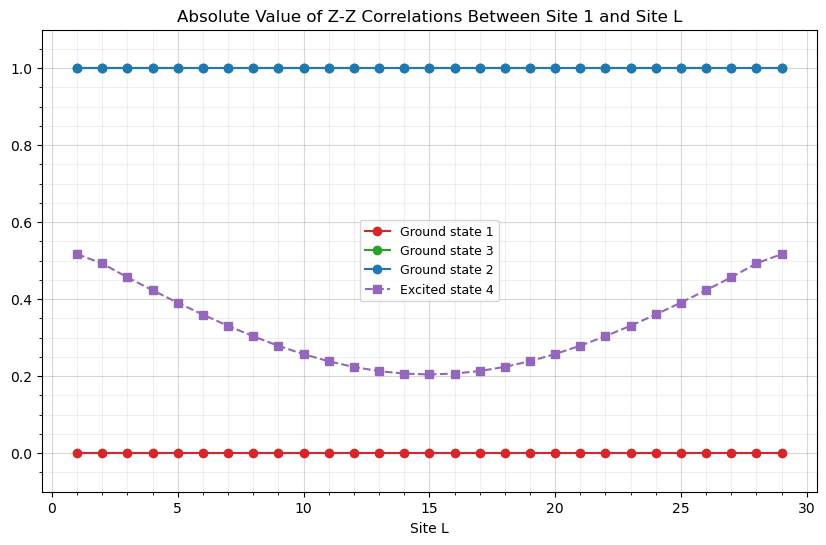

In [39]:
using PythonPlot

# Get the absolute values of correlations
abs_C1zz = abs.(C1zz[1, 2:end])
abs_C2zz = abs.(C2zz[1, 2:end])
abs_C3zz = abs.(C3zz[1, 2:end])
abs_C4zz = abs.(C4zz[1, 2:end]) # Excited state

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
x1 = collect(1:length(abs_C1zz))
plot(x1, abs_C1zz, marker="o", linestyle="-", color="tab:red", linewidth=1.5, 
     label="Ground state $(ground_state_labels[1])")
x2 = collect(1:length(abs_C2zz))
plot(x2, abs_C2zz, marker="o", linestyle="-", color="tab:green", linewidth=1.5,
     label="Ground state $(ground_state_labels[2])")
x3 = collect(1:length(abs_C3zz))
plot(x3, abs_C3zz, marker="o", linestyle="-", color="tab:blue", linewidth=1.5,
     label="Ground state $(ground_state_labels[3])")

# Plot the Z-Z correlations for excited state
x4 = collect(1:length(abs_C4zz))
plot(x4, abs_C4zz, marker="s", linestyle="--", color="tab:purple", linewidth=1.5,
     label="Excited state $(excited_state_label)")

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
    
# Adjusting graph
ymax = max(maximum(abs_C1zz), maximum(abs_C2zz), maximum(abs_C3zz), maximum(abs_C4zz))
ymin = min(minimum(abs_C1zz), minimum(abs_C2zz), minimum(abs_C3zz), minimum(abs_C4zz))
ylim(ymin - 0.1, ymax + 0.1)
minorticks_on()
    
# Print max and min values for reference
println("Max and Min Correlations for Ground States:")
println("State $(ground_state_labels[1]): max = $(round(maximum(abs_C1zz), digits=4)), min = $(round(minimum(abs_C1zz), digits=4))")
println("State $(ground_state_labels[2]): max = $(round(maximum(abs_C2zz), digits=4)), min = $(round(minimum(abs_C2zz), digits=4))")
println("State $(ground_state_labels[3]): max = $(round(maximum(abs_C3zz), digits=4)), min = $(round(minimum(abs_C3zz), digits=4))")
println("\nMax and Min Correlations for Excited State:")
println("State $(excited_state_label): max = $(round(maximum(abs_C4zz), digits=4)), min = $(round(minimum(abs_C4zz), digits=4))")